#cegads-domestic-model
This ipython notebook describes the basic usage of the cegads-domestic-model python library. The library implements a simple domestic appliance model based on data from chapter three of the DECC ECUK publication (https://www.gov.uk/government/collections/energy-consumption-in-the-uk). and provides a convenient interface for generating household simulations at the appliance level.

##Installation

`pip install` **`[--upgrade]`** `cegads-domestic-model`

or visit the [github repo](http://www.github.com/IESD/cegads-domestic-model) and download the code.

The implementation is based on [`pandas`](http://pandas.pydata.org/) so you will need to install that before it will work.

##iPython setup
I'm now going to setup ipython with the **`%pylab inline`** magic to prepare *`matplotlib`* to create inline plots. I also *`import pandas`* which will be used later.

In [1]:
%pylab inline
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


##`cegads.Scenario`
**`Scenario`** instances encapsulate domestic consumption statistics for a given year and enable the creation of **`Household`** and **`Appliance`** instances with characteristics drawn from those data. Most basic usage of this library will start with the creation of a `Scenario`.


To create a `Scenario`, it is recommended to use a **`ScenarioFactory`**.  

Here I import the `ScenarioFactory` class and instantiate a `ScenarioFactory` instance.

In [2]:
from cegads import ScenarioFactory
factory = ScenarioFactory()

The default `ScenarioFactory` inherits from the `ECUK` class which loads the full ECUK dataset. The `ScenarioFactory` loads data from the ECUK tables 3.08 (the number of households in UK by year), 3.10 (the total consumption of each appliance category by year) and 3.12 (appliance ownership by year). It calculates the number of appliances per household and the consumption per appliance for all available years.

We can inspect the data, though this is not part of the public API and so may change.

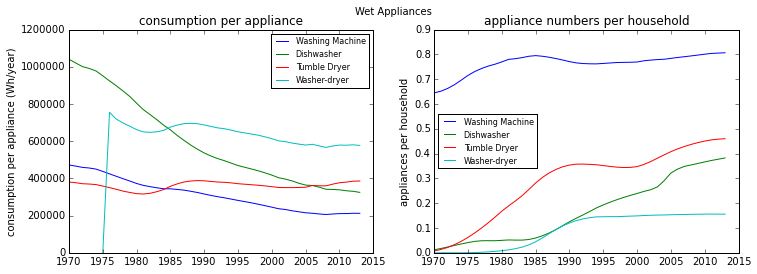

In [3]:
wet_appliance_keys = ['Washing Machine', 'Dishwasher', 'Tumble Dryer', 'Washer-dryer']
df = factory._data.stack().unstack(level=0)
f, [ax1,ax2] = plt.subplots(1, 2, figsize=(12, 4))
for key in wet_appliance_keys:
    ax1.plot(df.unstack(level=0).index, df[key]['consumption_per_appliance'], label=key)
    ax2.plot(df.unstack(level=0).index, df[key]['appliances_per_household'], label=key)
plt.suptitle("Wet Appliances")
ax2.set_title("appliance numbers per household")
ax2.set_ylabel("appliances per household")
ax2.legend(loc=6, fontsize=8)
ax1.set_title("consumption per appliance")
ax1.set_ylabel("consumption per appliance (Wh/year)")
ax1.legend(loc=1, fontsize=8)
plt.show()

The `ScenarioFactory` is callable directly. Calling the factory with an integer year value will return a `Scenario` instance loaded with data from the requested year. 

I can now pass a year into the factory to generate my `Scenario`. Here I load data from 2013.

In [4]:
year = 2013
scenario = factory(year)

We can inspect the underlying data for the given year. Here I extract the data and create a plot showing appliances per household. For most appliances the number per household is less than 1.0.

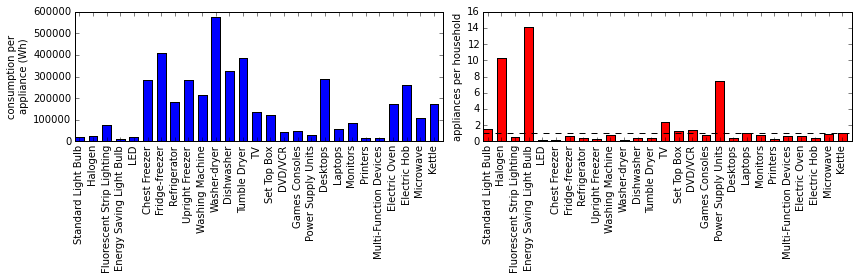

In [5]:
f, [ax2, ax1] = plt.subplots(1, 2, figsize=(12, 4), sharex=True)
ind = np.arange(len(scenario.index))
width = 0.65
ax1.bar(ind, scenario.appliances_per_household, width, color="red")
ax2.bar(ind, scenario.consumption_per_appliance, width, color="blue")
for ax in [ax1,ax2]:
    ax.set_xticks(ind+width/2.)
    ax.set_xticklabels(scenario.index, rotation=90)
    ax.set_xlim(0, len(scenario._data.index))
ax1.axhline(y=1, ls="--", color="black", lw=1)
ax1.set_ylabel("appliances per household")
ax2.set_ylabel("consumption per\nappliance (Wh)")
plt.tight_layout()

##Generating `Appliance` instances
`Scenario` instances are a convenient source of `Appliance` instances. The `Scenario.appliance()` method returns an appliance of the requested type with the appropriate annual consumption value allocated from the scenario data. In order to generate an appliance it is necessary to also provide a value for the appliances duty_cycle. Since all appliances are modelled as square waves, this value determines the wavelength of the square wave.

Here I create appliance instances for the wet appliances.

In [6]:
test_appliances = [scenario.appliance(app, 60) for app in wet_appliance_keys]
test_appliances

[Appliance(Washing Machine, 60, 581.3243121883295),
 Appliance(Dishwasher, 60, 890.228046579048),
 Appliance(Tumble Dryer, 60, 1057.4426827342268),
 Appliance(Washer-dryer, 60, 1581.738158886552)]

The appliances are represented above by three attributes: the appliance name; the duty_cycle; and the daily consumption. The first two were provided as arguments to the `Scenario.appliance` method, the last one was allocated by the scenario by dividing the annual consumption per appliance figure by 365.

`Appliance` instances contain a reference to an `ApplianceModel` instance which does the heavy lifting. `ApplianceModel` instances have access to data from table 3.11 in the ECUK data and (for appliances that are mapped) can access a daily profile shape from here. The profile can be used with the daily total consumption to generate a consumption profile adjusted for the scenario year.

In the case of wet appliances there is only one profile provided in the ECUK data. As a consequence, though they have different magnitudes, all the wet appliances have the same shape. 

Here I plot the cumulative distribution used by the model and also construct a consumption profile for each of the wet appliances.

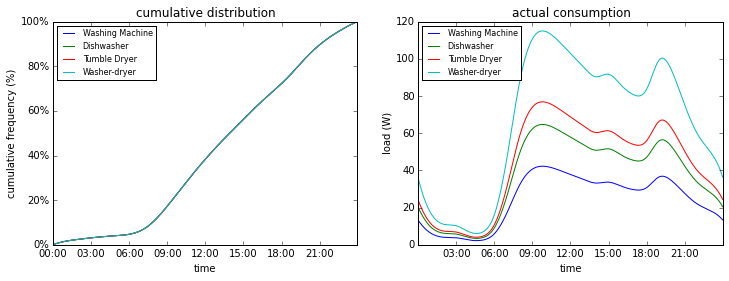

In [7]:
f, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 4))
for app in test_appliances:
    ax1.plot(app.profile.index, app.profile * 100, label=app.name)
    ax2.plot(app.profile.index, app.profile.diff()*60*app.daily_total, label=app.name) # * 60 for Wh -> W conversion
ax1.legend(loc=2, fontsize=8)
ax2.legend(loc=2, fontsize=8)
ax1.set_title("cumulative distribution")
ax2.set_title("actual consumption")
ax1.set_ylabel('cumulative frequency (%)')
ax2.set_ylabel('load (W)')
for ax in [ax1, ax2]:
    ax.set_xlabel('time')
    ax.xaxis.set_major_locator(mpl.dates.HourLocator(interval=3))
    ax.xaxis.set_major_formatter(mpl.dates.DateFormatter("%H:%M"))
ax1.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter("%.0f%%"))
plt.show()

##Appliance simulation
To generate a simulated dataset, call the `Appliance.simuation()` method. The method requires the number of days and the required frequency (in pandas format) as arguments. It can also take optional keyword arguments (in this case I have passed in a start date - the default would be `datetime.datetime.today()`).

I have concatenated four simulations into a list. Each result is a `pandas.Series`.

In [8]:
freq = "1Min"
start = datetime.datetime(year, 1, 1)
days = 7

test_simulations = [app.simulation(days, freq, start=start) for app in test_appliances]

Plotting the results shows the square wave form of the simulation. There is one duty cycle each day. The width of the cycle is determined by the user, the height is calculated from the cycle width and the daily consumption figure. The timing of the cycle is determined by drawing randomly from the overall consumption distribution.

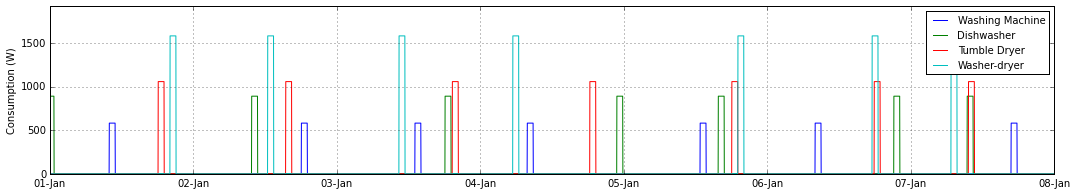

In [9]:
f, ax = plt.subplots(1, 1, figsize=(18, 3))
for app, sim in zip(test_appliances, test_simulations):
    ax.plot(sim.index, sim*60, label=app.name)
ax.legend(fontsize=10, loc="best")
ax.xaxis.set_major_formatter(mpl.dates.DateFormatter("%d-%b"))
ax.set_ylabel("Consumption (W)")
ax.set_ylim(top=ax.get_ylim()[1]*1.2)
ax.grid()
plt.show()

##Generating `Household` instances
`Household` objects are a simple collection of `Appliance` instances with convenient wrapper functions to run simulations and return merged `pandas.DataFrame` objects containing the simulation results for each appliance.

As we saw above, the `Scenario` instance has information about how many appliances of each type are owned per household. The `Scenario.household()` method uses this information to generate `Household` instances with the appropriate number of appliances. It returns a randomly generated `Household` instance with a collection of `Appliance` instances appropriate to the scenario year. 

The method takes a single argument. The argument is a list of 2-tuples as follows.

In [10]:
appliances_to_consider = [
    ('Washing Machine', 80),
    ('Dishwasher', 100),
    ('Tumble Dryer', 120),
    ('Washer-dryer', 180)
]

Each 2-tuple represents an appliance type and a duty_cycle. That is, the width of the square wave to be generated by the appliance during the simulation. Passing in these data as arguments to the `Scenario.household()` method will define the list of appliances to consider. 

> note: it is possible (and common) for a household to have no appliances


Here I create 150 households with a list comprehension, passing each the appliances_to_consider variable defined above. Looking at the first three items on the list we can see that Each household is loaded with appliances.

In [11]:
n = 150
households = [scenario.household(appliances_to_consider) for i in range(n)]
for h in households[:3]:
    print(h)

Household(Appliance(Dishwasher, 100, 890.228046579048), Appliance(Washing Machine, 80, 581.3243121883295), Appliance(Tumble Dryer, 120, 1057.4426827342268))
Household(Appliance(Dishwasher, 100, 890.228046579048), Appliance(Washing Machine, 80, 581.3243121883295))
Household(Appliance(Dishwasher, 100, 890.228046579048), Appliance(Washing Machine, 80, 581.3243121883295))


##Multiple-household simulation
Here I will use `pandas.concat` to combine the simulation results from all 150 households. I will also apply a unique name to each household to group the resulting dataset. Note that I am also ignoring empty households with a filter in the list comprehension.

**this is the step that generates the data - it may take a few seconds**

In [12]:
names = ["household {:03}".format(i + 1) for i, h in enumerate(households) if len(h)]
result = pd.concat([h.simulation(days, freq, start=start) for h in households if len(h)], keys=names, axis=1)
result.columns.names = ['household', 'appliance']

Now, I can plot the data from some of these households.

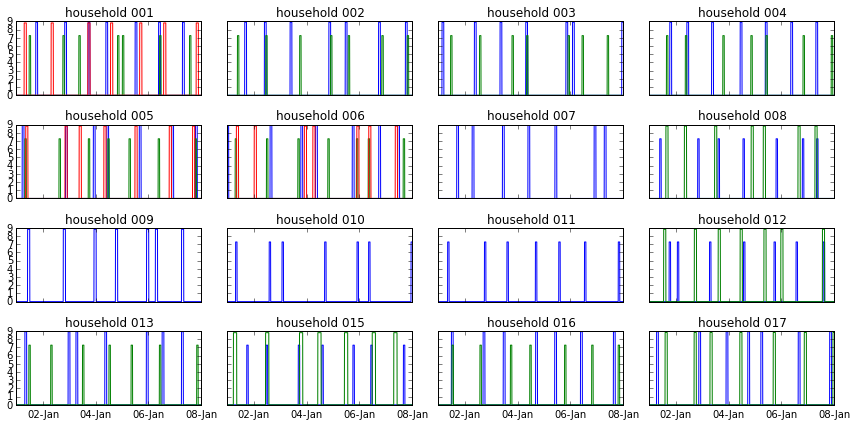

In [13]:
loc = mpl.dates.DayLocator(interval=2)
fmt = mpl.dates.DateFormatter("%d-%b")
xax, yax = 4, 4
f, axes = plt.subplots(xax, yax, sharex=True, sharey=True, figsize=(12, 6))
for row, ax_row in enumerate(axes):
    for col, ax in enumerate(ax_row):
        name = names[row*yax + col]
        for key in result[name]:
            ax.plot(result.index, result[name][key])
        ax.set_title(name)
        ax.xaxis.set_major_locator(loc)
        ax.xaxis.set_major_formatter(fmt)

plt.tight_layout()
plt.show()

Combining the results from all the households produces a bit of a mess. We can see that the overall usage pattern is structured.

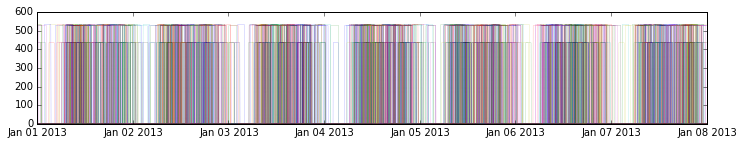

In [14]:
f, ax = plt.subplots(figsize=(12, 2))
ax.plot(result.index, result*60, alpha=0.5, lw=0.25)
plt.show()

The mean consumption of each appliance type shows that there are differences between appliances with washer-dryers consuming the most and washing machines the least. This is a reflection of the data in ECUK table 3.10.

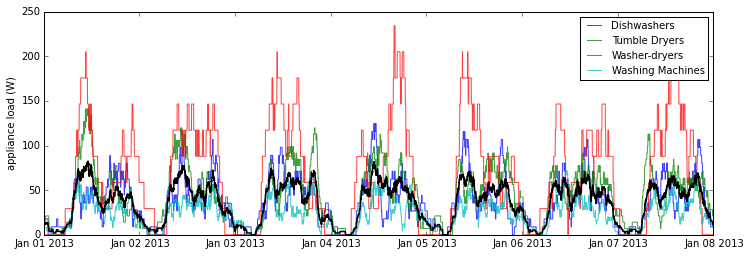

In [15]:
df = result.copy()
df.columns = df.columns.droplevel()
appliance_mean_profile = df.groupby(df.columns, axis=1).mean()

f, ax = plt.subplots(figsize=(12, 4))
for key in appliance_mean_profile:
    ax.plot(appliance_mean_profile.index, appliance_mean_profile[key]*60, alpha=0.75, label="{}{}".format(key[:-2], 's'))

ax.plot(df.index, df.mean(axis=1)*60, color="black", lw=1.5) #average across all households
ax.set_ylabel("appliance load (W)")
plt.legend(fontsize=10)
plt.show()

##Discussion
So the library has generated minutely profiles of consumption for each appliance in 150 households. If the model works correctly we should see that the model profile presented above matches the simulated output. That is, we should see that the combination of all the square waves should match roughly with the smooth model profile for each appliance type. This is the ultimate purpose of the model.

###Total consumption
Total consumption for each appliance type is determined by the ECUK data in table 3.10. We can dig into the library to find these raw figures.

In [16]:
from cegads import ECUK
ecuk = ECUK()

for device in wet_appliance_keys:
    print("{:20} {}".format(device, ecuk(2013, device).consumption_per_appliance / 365))

Washing Machine      581.3243121883295
Dishwasher           890.228046579048
Tumble Dryer         1057.4426827342268
Washer-dryer         1581.738158886552


We can now look at the average daily consumption of each appliance type in our simulation to see if they match.

In [17]:
totals = df.sum() / 7                     # total consumption divided by 7 for each appliance
totals.groupby(totals.index).mean()       # average across all appliance types

appliance
Dishwasher_1          887.726930
Tumble Dryer_1       1052.507950
Washer-dryer_1       1580.971002
Washing Machine_1     580.638609
dtype: float64

We might expect these figures to match precisely but in fact they don't. This is due to an artifact in the modelling process. Sometimes a duty cycle begins near the end of the simulation period (or ends near the beginning) and so consumption for that cycle actually passes over the edge of the dataset. We **can** expect that simulated consumption should never exceed these figures. It is only a problem at the very edges of the simulation period (though at the boundary between days it is possible for an appliance to be running two duty cycles at the same time). This can be improved.

###Overall consumption profile
The profile of consumption is also determined by the ECUK data (table 3.11). We can access the data by digging into appliance instances. Due to the limitations of the raw data all wet appliances share the same profile, but have different consumption levels.

Running 365-day simulations on the example appliances allows us to generate comparable simulated average profiles.

In [18]:
sims = [app.simulation(365, "30Min") for app in test_appliances]

In [19]:
shapes = [sim.groupby(sim.index.time).mean() for sim in sims]

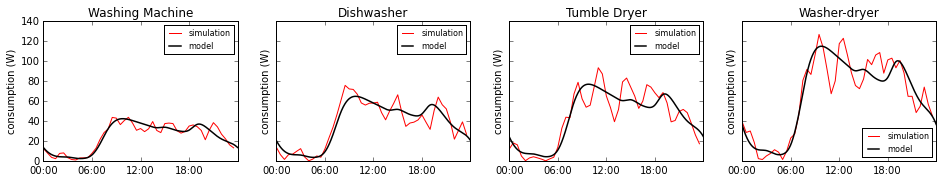

In [20]:
f, axes = plt.subplots(1, len(sims), figsize=(16, 2.5), sharey=True)
for ax, app, shape in zip(axes, test_appliances, shapes):
    i = [datetime.datetime.combine(app.profile.index[0], t) for t in shape.index]
    ax.plot_date(i, shape * 2, color='red', label="simulation", ls="-", marker=None) # convert Wh per half-hour to W (*2)
    ax.plot(app.profile.index, app.profile.diff() * app.daily_total * 60, color="black", lw=1.5, label="model")
    ax.set_title(app.name)
    ax.xaxis.set_major_locator(mpl.dates.HourLocator(interval=6))
    ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%H:%M'))
    ax.set_ylabel("consumption (W)")
    ax.legend(loc="best", fontsize=8)

It is very clear that the simulated data matches both the shape and the magnitude of the model profiles very closely. Of course, these are randomly generated profiles based on square waves so they are not expected to fit perfectly.